# Создание сервиса для нахождения рыночной стоимости авто

В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Предстоит построить модель для определения стоимости, предварительно подготовив данные.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Содержание:
* <a href='#Подготовка данных'>1. Подготовка данных.
    * <a href='#Визуализация'>1.2 Визуализация.
* <a href='#Обучение моделей'> 2. Обучение моделей.
    * <a href='#Линейная регрессия'> 2.1 Линейная регрессия.
    * <a href='#Решающее дерево'> 2.2 Решающее дерево.
    * <a href='#Случайный лес'> 2.3 Случайный лес.
    * <a href='#CatBoost'> 2.4 CatBoost.
    * <a href='#LightGBM'> 2.5 LightGBM.
* <a href='#Анализ моделей'> 3. Анализ моделей.

# 1. Подготовка данных
<a id='Подготовка данных'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import warnings; warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/autos.csv')
display(data.head())
display(data.info())
print('Пропуски:')
display(data.isna().sum())
print('Дубликаты:')
display(data.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

Пропуски:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Дубликаты:


4

In [3]:
threshhold = 4 # установим допустимый порог количества пропусков.
data.dropna(axis=0, thresh=(data.shape[1] - threshhold))
print('Удалим строки в которых больше {} пропусков. Таких строк было {:.2%} от всего датасета.'.format(threshhold,
                        ((len(data) - len(data.dropna(axis=0, thresh=(data.shape[1] - threshhold)))) / len(data))))

Удалим строки в которых больше 4 пропусков. Таких строк было 0.63% от всего датасета.


In [4]:
# Приведём данные к нужным типам
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')
# И сразу извлечём их в отдельные стоблцы
# DateCrawled
data['YearCrawled'] = pd.DatetimeIndex(data['DateCrawled']).year
data['MonthCrawled'] = pd.DatetimeIndex(data['DateCrawled']).month
data['DayCrawled'] = pd.DatetimeIndex(data['DateCrawled']).day
data = data.drop(['DateCrawled'], axis=1)
# DateCreated
data['YearCreated'] = pd.DatetimeIndex(data['DateCreated']).year
data['MonthCreated'] = pd.DatetimeIndex(data['DateCreated']).month
data['DayCreated'] = pd.DatetimeIndex(data['DateCreated']).day
data = data.drop(['DateCreated'], axis=1)
# LastSeen
data['YearLastSeen'] = pd.DatetimeIndex(data['LastSeen']).year
data['MonthLastSeen'] = pd.DatetimeIndex(data['LastSeen']).month
data['DayLastSeen'] = pd.DatetimeIndex(data['LastSeen']).day
data = data.drop(['LastSeen'], axis=1)

Посмотрим на пропуски в столбце 'VehicleType'

In [5]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Заполним пропуски в столбце 'VehicleType'. Поскольку в таблице не представленно некоторое количество популярных типов кузова автомобиля, стоит предположить, что пропуски можно заменить на 'other' не потеряв сильно в качесве.

In [6]:
data['VehicleType'] = data['VehicleType'].fillna('other')
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: VehicleType, dtype: int64

Посмотрим на пропуски в столбце 'Gearbox'

In [7]:
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [8]:
data[data['Gearbox'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,...,PostalCode,YearCrawled,MonthCrawled,DayCrawled,YearCreated,MonthCreated,DayCreated,YearLastSeen,MonthLastSeen,DayLastSeen
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,...,24148,2016,3,11,2016,3,11,2016,3,19
16,300,other,2016,NaN,60,polo,150000,0,petrol,volkswagen,...,38871,2016,4,1,2016,4,1,2016,4,1
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,...,44145,2016,3,15,2016,3,15,2016,3,17
37,1500,other,2016,NaN,0,kangoo,150000,1,gasoline,renault,...,46483,2016,3,28,2016,3,28,2016,3,30
40,0,other,1990,NaN,0,corsa,150000,1,petrol,opel,...,56412,2016,3,26,2016,3,26,2016,3,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,...,12057,2016,3,16,2016,3,16,2016,3,17
354305,3500,other,1995,NaN,0,polo,150000,0,NaN,volkswagen,...,74579,2016,4,3,2016,4,3,2016,4,5
354329,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,...,25436,2016,3,30,2016,3,30,2016,4,7
354338,180,other,1995,NaN,0,NaN,125000,3,petrol,opel,...,41470,2016,3,31,2016,3,31,2016,4,6


В случае с коробкой передач сложно найти соседей, так как часто машины с одинаковыми техническими характеристиками могут поставляться с различными вариантами коробки. Думаю хорошим вариантом в данном случае будет заполнение на 'no_info'. Возможно, отсутствие информации тоже что-то значит.

In [9]:
data['Gearbox'] = data['Gearbox'].fillna('no_info')

Посмотрим на пропуски в столбце 'Model':

In [10]:
data[data['Model'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,...,PostalCode,YearCrawled,MonthCrawled,DayCrawled,YearCreated,MonthCreated,DayCreated,YearLastSeen,MonthLastSeen,DayLastSeen
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,...,66954,2016,3,24,2016,3,24,2016,4,7
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,...,53721,2016,3,29,2016,3,29,2016,4,6
81,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,...,45665,2016,4,3,2016,4,3,2016,4,5
115,0,small,1999,no_info,0,NaN,5000,0,petrol,volkswagen,...,37520,2016,3,20,2016,3,20,2016,4,7
135,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,...,38709,2016,3,27,2016,3,27,2016,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354245,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,...,55743,2016,3,7,2016,3,7,2016,3,12
354321,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,...,91186,2016,3,15,2016,3,15,2016,3,17
354338,180,other,1995,no_info,0,NaN,125000,3,petrol,opel,...,41470,2016,3,31,2016,3,31,2016,4,6
354351,1900,other,2000,manual,110,NaN,150000,7,NaN,volkswagen,...,87700,2016,3,11,2016,3,11,2016,3,12


In [11]:
%%time
def model_filler(row):
    if pd.isnull(row['Model']) == True:
        model_table = data[(data['Brand'] == row['Brand']) & 
          (data['VehicleType'] == row['VehicleType']) & 
              ((data['Power'][(data['Brand'] == row['Brand']) & 
               (data['VehicleType'] == row['VehicleType'])]) == row['Power'])]['Model']
        if len(model_table.value_counts()) > 0:
            return model_table.value_counts().index[0]
        else:
            return row['Model']
    else:
        return row['Model']

    
data['Model'] = data.apply(model_filler, axis=1)
data[data['Model'].isna()]

CPU times: user 1h 11min 30s, sys: 3.36 s, total: 1h 11min 33s
Wall time: 1h 12min 10s


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,...,PostalCode,YearCrawled,MonthCrawled,DayCrawled,YearCreated,MonthCreated,DayCreated,YearLastSeen,MonthLastSeen,DayLastSeen
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,...,53721,2016,3,29,2016,3,29,2016,4,6
306,200,other,2009,no_info,0,NaN,10000,0,NaN,sonstige_autos,...,6493,2016,3,21,2016,3,21,2016,3,24
431,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,...,90562,2016,3,20,2016,3,20,2016,4,3
650,15000,coupe,1971,no_info,0,NaN,5000,4,NaN,sonstige_autos,...,51145,2016,3,30,2016,3,30,2016,4,7
661,9900,suv,2000,auto,250,NaN,150000,4,lpg,sonstige_autos,...,17309,2016,4,1,2016,4,1,2016,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354062,6000,small,2008,manual,155,NaN,150000,5,petrol,sonstige_autos,...,63069,2016,3,19,2016,3,19,2016,4,7
354073,1750,other,1995,no_info,0,NaN,100000,12,NaN,sonstige_autos,...,6188,2016,3,19,2016,3,19,2016,4,1
354083,0,other,2000,no_info,0,NaN,150000,0,NaN,sonstige_autos,...,6686,2016,3,30,2016,3,30,2016,4,6
354321,9400,wagon,2007,manual,200,NaN,150000,4,gasoline,sonstige_autos,...,91186,2016,3,15,2016,3,15,2016,3,17


Посмотрим на пропуски в столбце 'FuelType':

In [12]:
data[data['FuelType'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,...,PostalCode,YearCrawled,MonthCrawled,DayCrawled,YearCreated,MonthCreated,DayCreated,YearLastSeen,MonthLastSeen,DayLastSeen
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,...,27472,2016,3,17,2016,3,17,2016,3,31
13,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,...,90762,2016,3,21,2016,3,21,2016,3,23
26,5555,other,2017,manual,125,c4,125000,4,NaN,citroen,...,31139,2016,3,10,2016,3,10,2016,3,16
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,...,2943,2016,3,11,2016,3,11,2016,4,7
41,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,...,33649,2016,3,30,2016,3,30,2016,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354339,3850,convertible,2006,manual,108,2_reihe,125000,2,NaN,peugeot,...,53947,2016,3,20,2016,3,20,2016,3,26
354346,2600,other,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,...,61169,2016,3,7,2016,3,7,2016,3,8
354351,1900,other,2000,manual,110,golf,150000,7,NaN,volkswagen,...,87700,2016,3,11,2016,3,11,2016,3,12
354361,5250,other,2016,auto,150,159,150000,12,NaN,alfa_romeo,...,51371,2016,3,9,2016,3,9,2016,3,13


Информацию о типе топлива можно получить, зная мощность двигателя и название производителя. Напишем функцию для решения этой задачи. Проблема функции будет в том, что придётся искать ближайший соседей, вместо точного равенства в мощности, это может создать модельный шум.

In [13]:
%%time
def fueltype_filler(row):
    if pd.isnull(row['FuelType']) == True:
        brand_table = data[data['Brand'] == row['Brand']].pivot_table(index='FuelType', values='Power', aggfunc='median')
        power = row['Power']
        return brand_table[brand_table['Power'] == min(brand_table['Power'], key=lambda x: abs(x - power))].index[0]
    else:
        return row['FuelType']
    
data['FuelType'] = data.apply(fueltype_filler, axis=1)

CPU times: user 27min 2s, sys: 1.57 s, total: 27min 3s
Wall time: 27min 17s


Посмотрим на пропуски в столбце 'NotRepaired':

In [14]:
data['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [15]:
data[data['NotRepaired'] == 'no']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,...,PostalCode,YearCrawled,MonthCrawled,DayCrawled,YearCreated,MonthCreated,DayCreated,YearLastSeen,MonthLastSeen,DayLastSeen
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,...,91074,2016,3,17,2016,3,17,2016,3,17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,...,60437,2016,3,31,2016,3,31,2016,4,6
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,...,67112,2016,4,1,2016,4,1,2016,4,5
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,...,19348,2016,3,21,2016,3,21,2016,3,25
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,...,96224,2016,3,26,2016,3,26,2016,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354360,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,...,81825,2016,4,2,2016,4,2,2016,4,6
354361,5250,other,2016,auto,150,159,150000,12,gasoline,alfa_romeo,...,51371,2016,3,9,2016,3,9,2016,3,13
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,...,26624,2016,3,27,2016,3,27,2016,3,29
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,...,26135,2016,3,5,2016,3,5,2016,3,11


В данном случаю думаю тоже правильно будет заменить пропуски третьим варинатом ('no_info').

In [16]:
data['NotRepaired'] = data['NotRepaired'].fillna('no_info')

Так же удалим дубликаты:

In [17]:
data = data.drop_duplicates()

In [18]:
print('Пропуски после обработки:')
display(data.isna().sum())

Пропуски после обработки:


Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model                3905
Kilometer               0
RegistrationMonth       0
FuelType                0
Brand                   0
NotRepaired             0
NumberOfPictures        0
PostalCode              0
YearCrawled             0
MonthCrawled            0
DayCrawled              0
YearCreated             0
MonthCreated            0
DayCreated              0
YearLastSeen            0
MonthLastSeen           0
DayLastSeen             0
dtype: int64

In [19]:
# удалим оставашиеся пропуски
data = data.dropna()
display(data.isna().sum())

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
NumberOfPictures     0
PostalCode           0
YearCrawled          0
MonthCrawled         0
DayCrawled           0
YearCreated          0
MonthCreated         0
DayCreated           0
YearLastSeen         0
MonthLastSeen        0
DayLastSeen          0
dtype: int64

## Вывод:
Там где было возможно, была проведена попытка заполнить пропущенные значения используя похожие строки, возможно, это добавило модельный шум и сказило наши данные. В остальных случае был добавлен маркер отсутствующих значений.

## Визуализируем данные
<a id='Визуализация'></a>

In [20]:
cat_columns = []
int_columns = []
for i in data.columns:
    if data[i].dtype == 'object':
        cat_columns.append(i)
    elif data[i].dtype == 'int64':
        int_columns.append(i)
    

print('Cat_columns:', cat_columns)
print('Int_columns:', int_columns)

Cat_columns: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
Int_columns: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'YearCrawled', 'MonthCrawled', 'DayCrawled', 'YearCreated', 'MonthCreated', 'DayCreated', 'YearLastSeen', 'MonthLastSeen', 'DayLastSeen']


In [21]:
def hister_bins_estimator(column):
    try:
        high = int(column.describe()['max'])
        low = int(column.describe()['min'])
        
        bins = high - low
        if bins > 40:
            bins = 40
        elif bins < 5:
            bins = bins * 4
        else:
            bins
    
        print('Минимум: {}. Максимум: {}'.format(low, high))
        column.plot(kind='hist', range=(low, high), bins=bins, grid=True, legend=True, figsize=(20,10))
        plt.title('Распределение: {}'.format(column.name))
        plt.show
    except ValueError:
        pass

Минимум: 0. Максимум: 20000


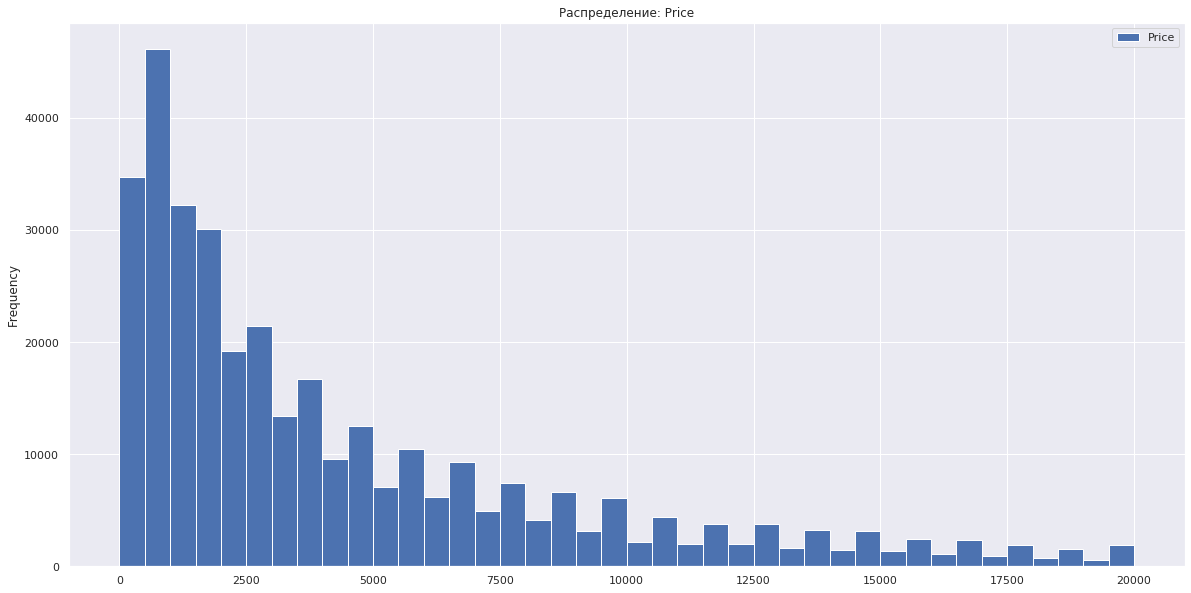

Минимум: 1000. Максимум: 9999


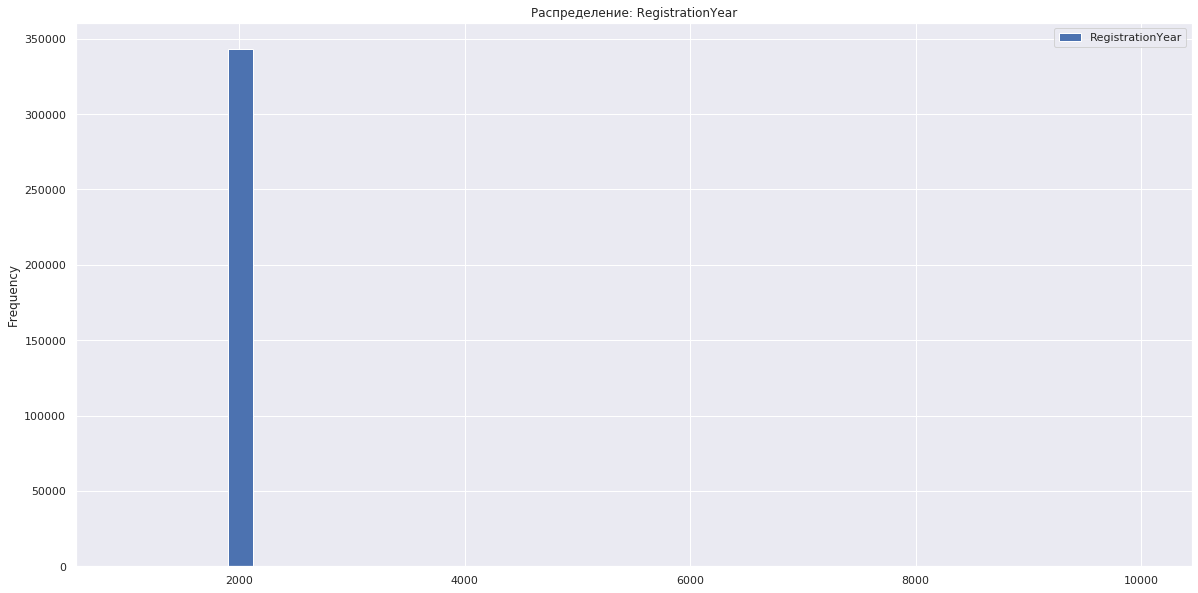

Минимум: 0. Максимум: 20000


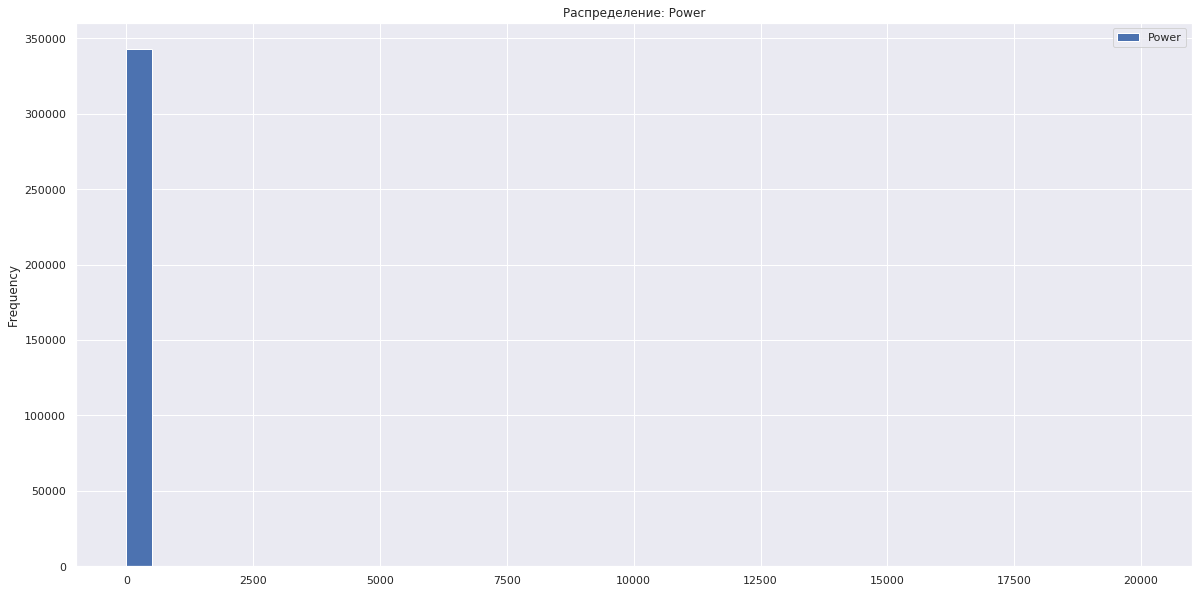

Минимум: 5000. Максимум: 150000


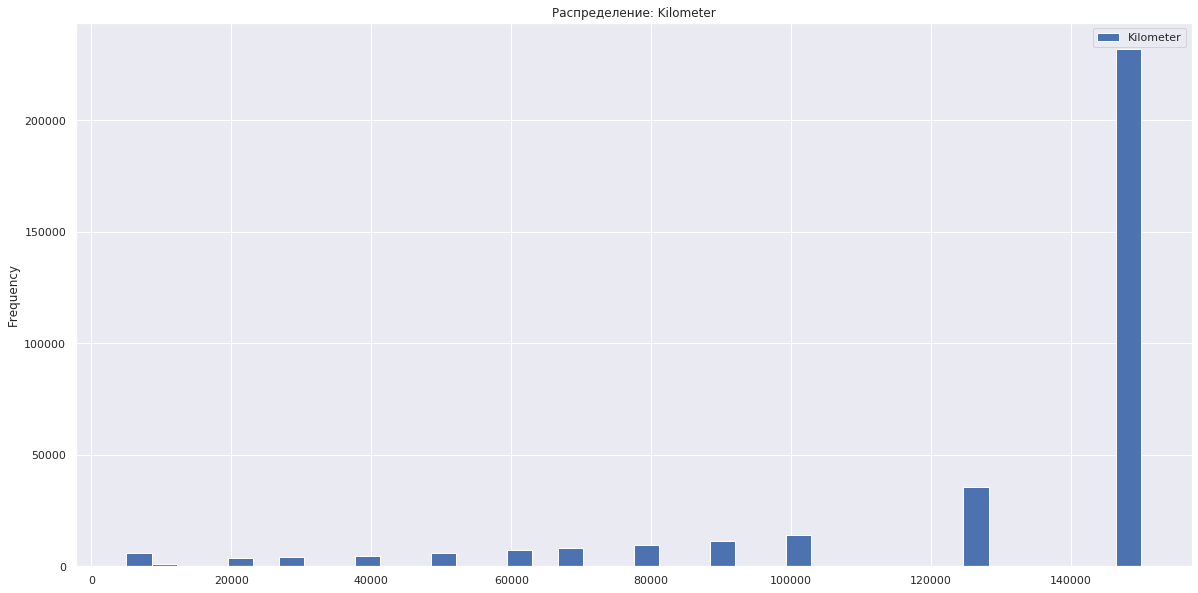

Минимум: 0. Максимум: 12


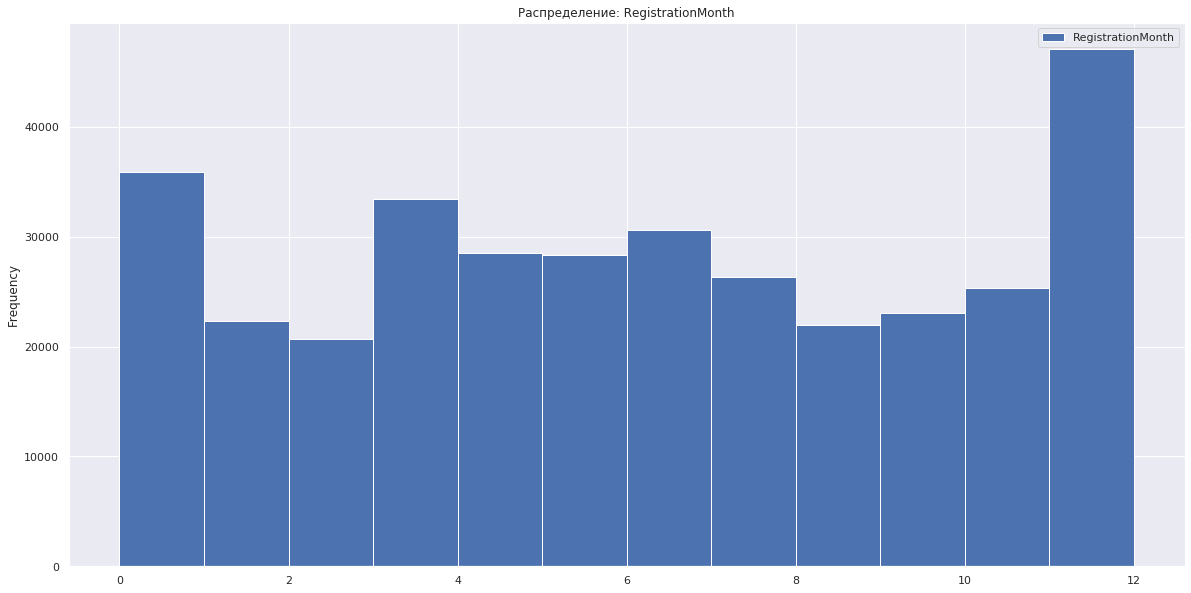

Минимум: 0. Максимум: 0
Минимум: 1067. Максимум: 99998


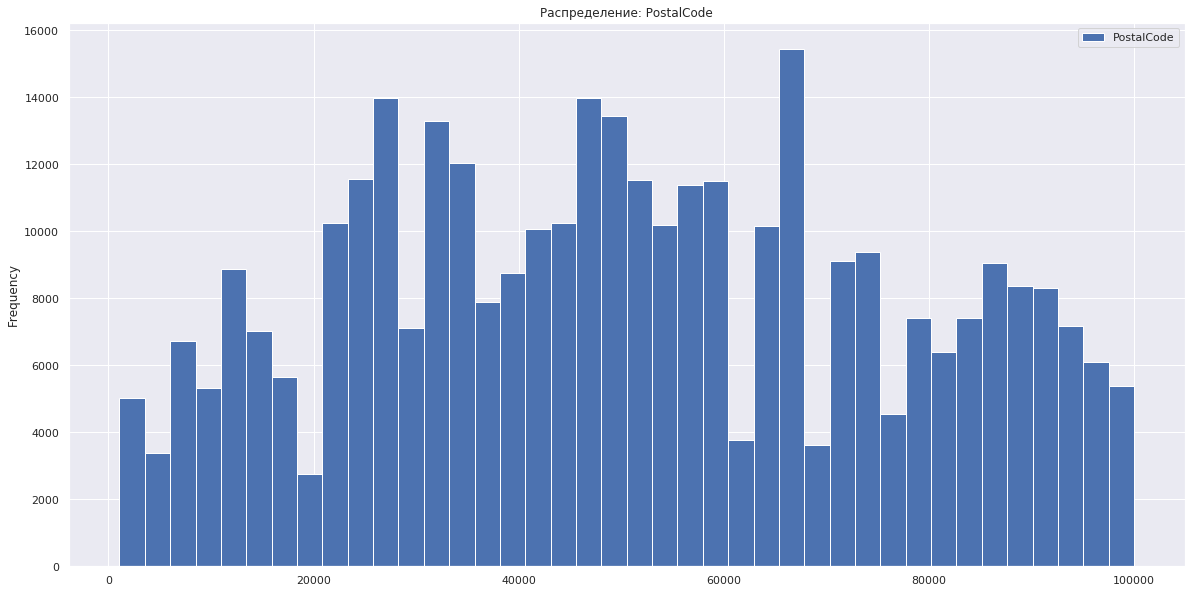

Минимум: 2016. Максимум: 2016
Минимум: 3. Максимум: 4


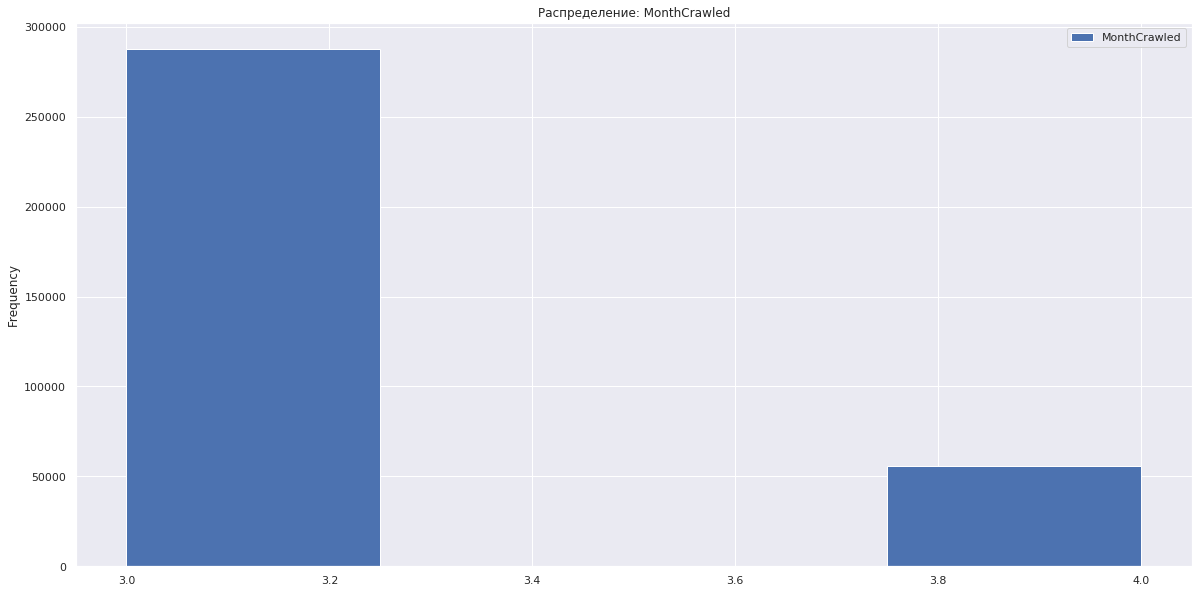

Минимум: 1. Максимум: 31


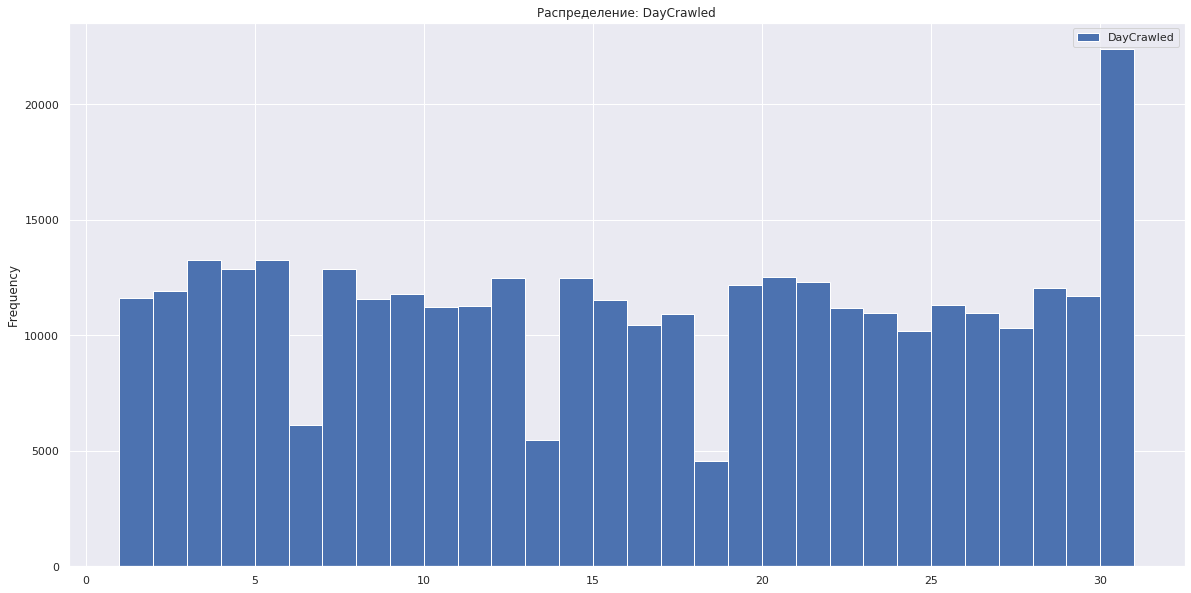

Минимум: 2014. Максимум: 2016


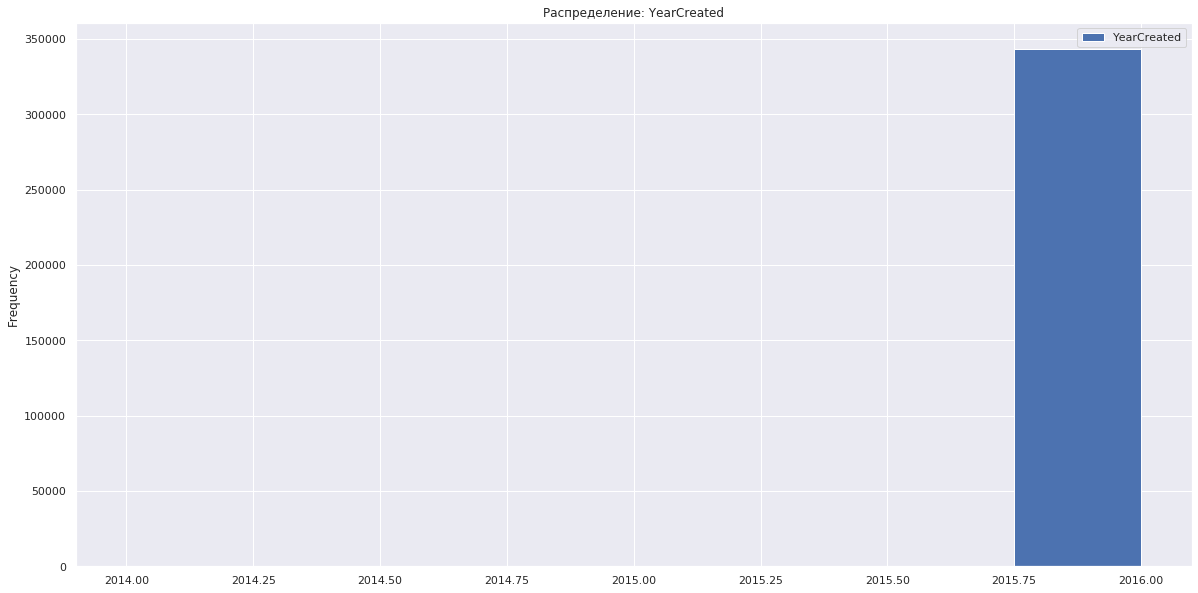

Минимум: 1. Максимум: 12


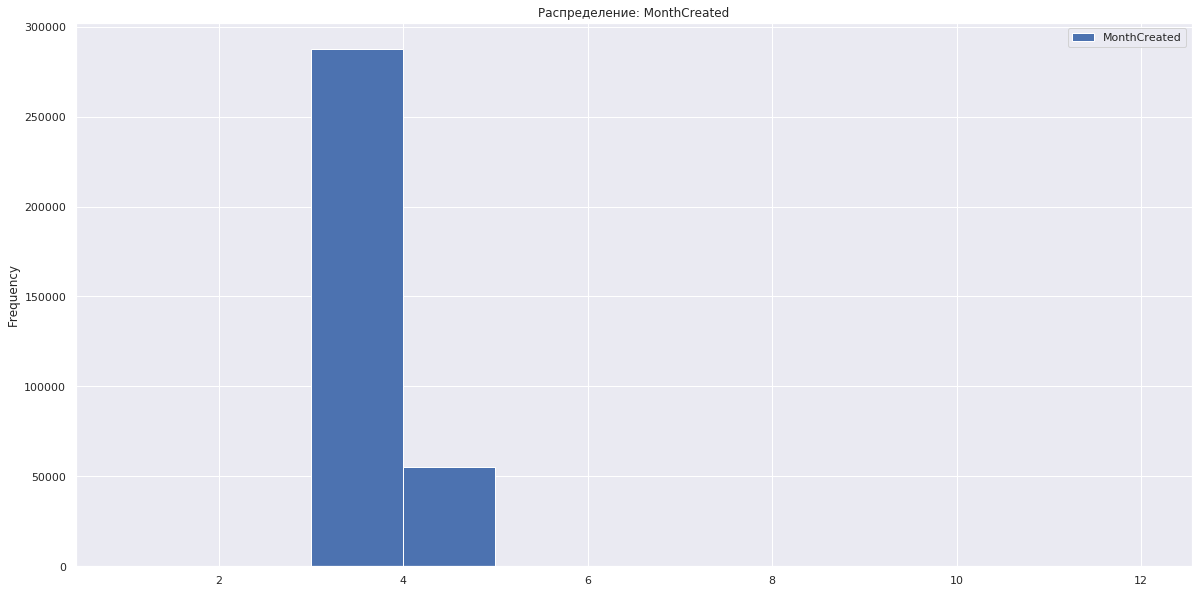

Минимум: 1. Максимум: 31


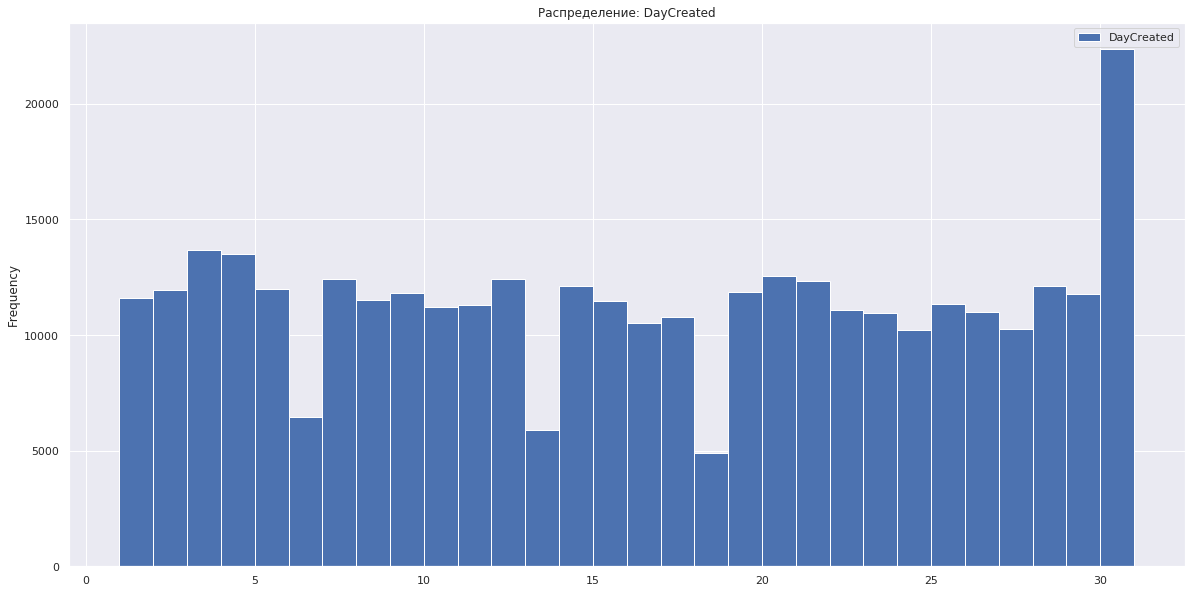

Минимум: 2016. Максимум: 2016
Минимум: 3. Максимум: 4


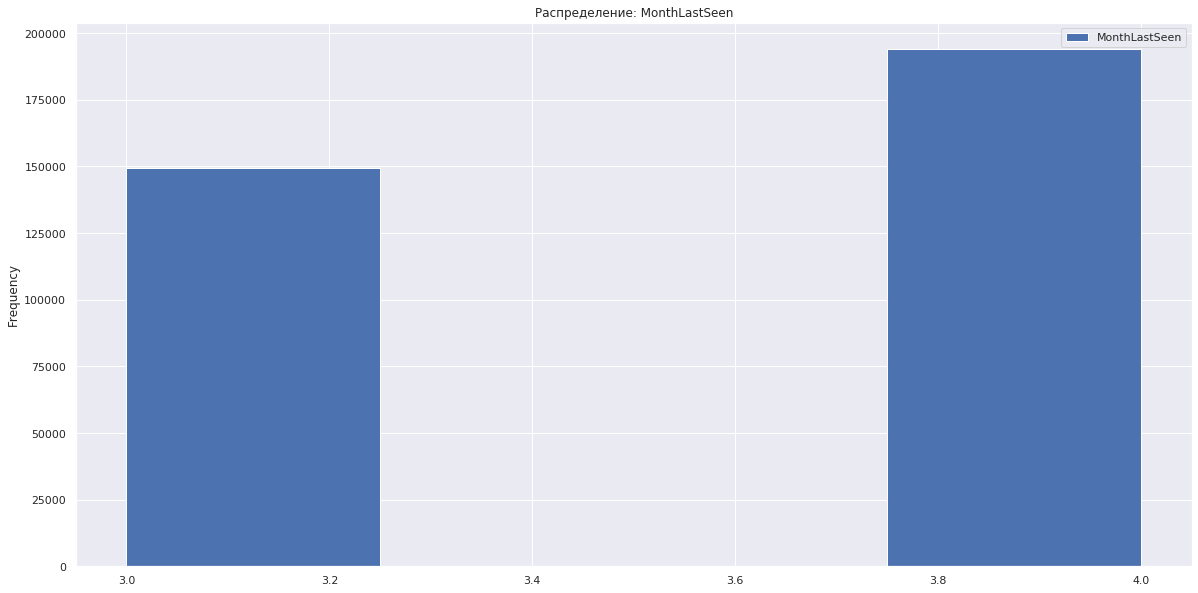

Минимум: 1. Максимум: 31


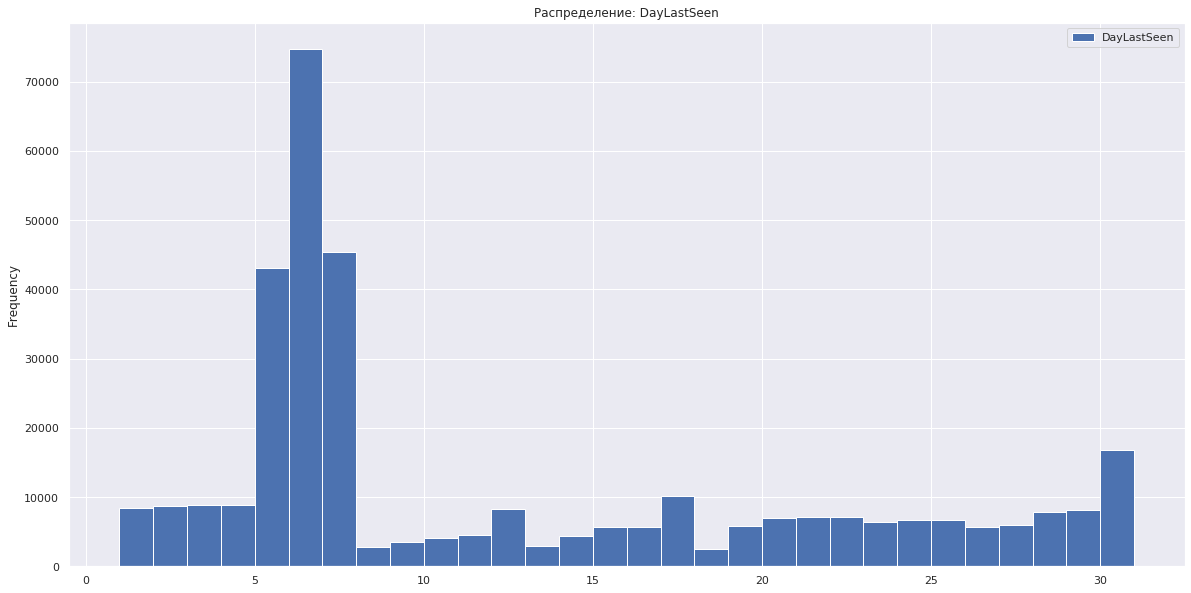

In [22]:
for i in int_columns:
    hister_bins_estimator(data[i])
    plt.show()

## Вывод из гистограммам:
В столбце 'Power' присутствует большое количесво нулевых значений. Думаю можно заменить эти значения на медианное для каждой модели авто. Для этой цели напишем простую функцию. И очень разброс до и после обработки.

In [23]:
data[data['Power'] == 0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,...,PostalCode,YearCrawled,MonthCrawled,DayCrawled,YearCreated,MonthCreated,DayCreated,YearLastSeen,MonthLastSeen,DayLastSeen
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,...,70435,2016,3,24,2016,3,24,2016,4,7
15,450,small,1910,no_info,0,ka,5000,0,petrol,ford,...,24148,2016,3,11,2016,3,11,2016,3,19
32,245,sedan,1994,no_info,0,golf,150000,2,petrol,volkswagen,...,44145,2016,3,15,2016,3,15,2016,3,17
37,1500,other,2016,no_info,0,kangoo,150000,1,gasoline,renault,...,46483,2016,3,28,2016,3,28,2016,3,30
40,0,other,1990,no_info,0,corsa,150000,1,petrol,opel,...,56412,2016,3,26,2016,3,26,2016,3,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354335,390,small,1997,auto,0,corsa,100000,6,petrol,opel,...,17509,2016,4,4,2016,4,4,2016,4,6
354336,3299,other,2005,auto,0,outlander,150000,4,petrol,mitsubishi,...,17034,2016,3,5,2016,3,5,2016,3,6
354338,180,other,1995,no_info,0,corsa,125000,3,petrol,opel,...,41470,2016,3,31,2016,3,31,2016,4,6
354346,2600,other,2005,auto,0,c_klasse,150000,9,hybrid,mercedes_benz,...,61169,2016,3,7,2016,3,7,2016,3,8


In [24]:
data['Power'].describe()

count    343543.000000
mean        109.750285
std         182.368614
min           0.000000
25%          69.000000
50%         105.000000
75%         141.000000
max       20000.000000
Name: Power, dtype: float64

In [25]:
%%time
def zero_power_remover(row):
    if row['Power'] != 0:
        return row['Power']
    if row['Power'] == 0:
        return data['Power'][data['Model'] == row['Model']].median()
         
    
        
data['Power'] = data.apply(zero_power_remover, axis=1)

CPU times: user 15min 21s, sys: 892 ms, total: 15min 22s
Wall time: 15min 29s


In [26]:
data[data['Power'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,...,PostalCode,YearCrawled,MonthCrawled,DayCrawled,YearCreated,MonthCreated,DayCreated,YearLastSeen,MonthLastSeen,DayLastSeen


In [27]:
data[data['Model'] == 'serie_1']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,...,PostalCode,YearCrawled,MonthCrawled,DayCrawled,YearCreated,MonthCreated,DayCreated,YearLastSeen,MonthLastSeen,DayLastSeen
234296,3800,wagon,1978,manual,0.0,serie_1,30000,0,gasoline,land_rover,...,49824,2016,3,30,2016,3,30,2016,3,30
280216,0,other,1970,no_info,0.0,serie_1,100000,0,petrol,land_rover,...,88634,2016,4,2,2016,4,2,2016,4,6


In [28]:
data['Power'].describe()

count    343543.000000
mean        121.184614
std         178.762808
min           0.000000
25%          75.000000
50%         109.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Так же разберемся с RegistrationYear.

In [29]:
def hister_with_quantile(column):
    try:
        iqr = column.describe()['75%'] - column.describe()['25%']
        high = int(column.describe()['75%'] + 3 * iqr)#Q3+3*IQR.
        low = int(column.describe()['25%'] - 3 * iqr)#Q1-3*IQR до 
        if low < 0:
            low = 0
    
        bins = high - low
        if bins > 40:
            bins = 40
        elif bins < 5:
            bins = bins * 4
        else:
            bins
    
        print('Минимум: {}. Максимум: {}'.format(low, high))
        column.plot(kind='hist', range=(low, high), bins=bins, grid=True, legend=True, figsize=(20,10))
        plt.title('Распределение: {}'.format(column.name))
        plt.show
    except ValueError:
        pass

In [30]:
data['RegistrationYear'].describe()

count    343543.000000
mean       2004.060330
std          79.526174
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Минимум: 1972. Максимум: 2035


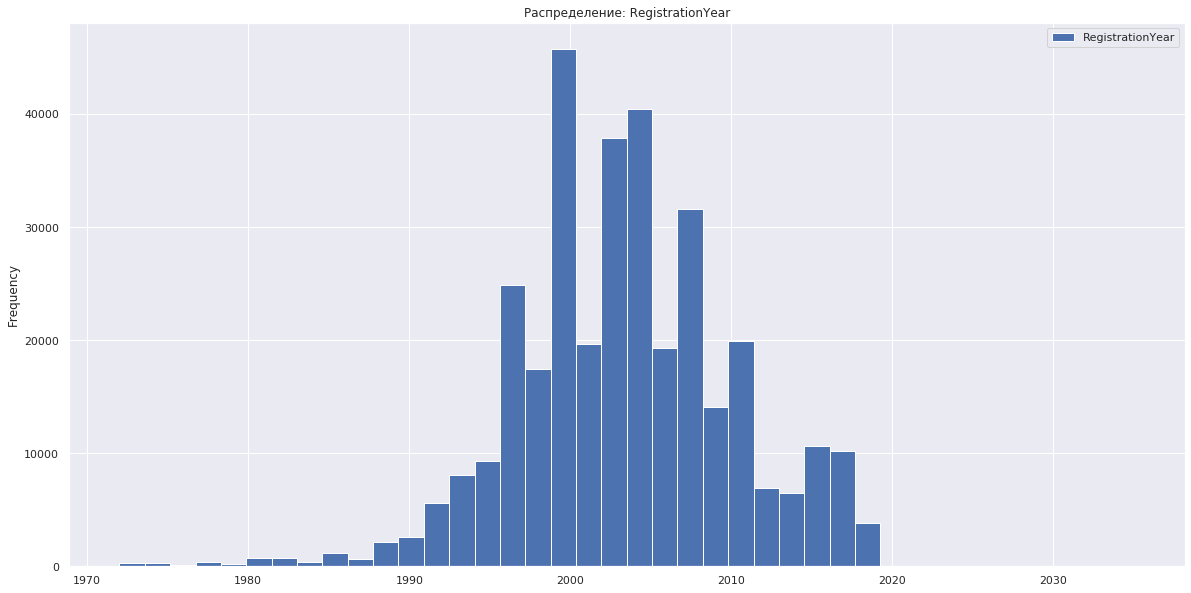

In [31]:
# Определим диапазон значений без выбросов:
hister_with_quantile(data['RegistrationYear'])

In [32]:
print('Удалим выбросы из столбца RegistrationYear. Они занимали {:.2%} от всего датасета.'.format(
    (len(data) - len(data.query('1950 < RegistrationYear < 2020'))) / len(data)))
data = data.query('1950 < RegistrationYear < 2020')

Удалим выбросы из столбца RegistrationYear. Они занимали 0.08% от всего датасета.


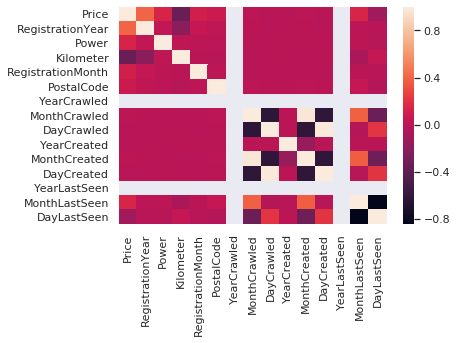

In [33]:
# посмотрим на хитмап
ax = sns.heatmap(data.drop('NumberOfPictures', axis=1).corr())

## Вывод:
Визуализация выявила два проблемных признака с выбросами: год регистрации и мощность двигателя. В случае с мощностью нули были заменены на среднее значения для каждой конкретной модели, а для даты регистрации данные были просто удалены.

# 2. Обучение моделей
<a id='Обучение моделей'></a>
Разделим данные на две выборки:

In [34]:
# оставим варинат без обработанных признаков
data_train, data_test = train_test_split(data, test_size=0.3, random_state=1)


# тренировочная 
features_train = data_train.drop(['Price'], axis=1)
target_train = data_train['Price']
# тестовая
features_test = data_test.drop(['Price'], axis=1)
target_test = data_test['Price']


# создадим версию датасета с обработанными категориальными признаками
dummie_data = pd.get_dummies(data)
dummie_data_train, dummie_data_test = train_test_split(dummie_data, test_size=0.3, random_state=1)


# тренировочная 
dummie_features_train = dummie_data_train.drop(['Price'], axis=1)
dummie_target_train = dummie_data_train['Price']
# тестовая
dummie_features_test = dummie_data_test.drop(['Price'], axis=1)
dummie_target_test = dummie_data_test['Price']

# Линейная регрессия
<a id='Линейная регрессия'></a>

In [35]:
# тут используем дамми обработанные данные
lr_model = LinearRegression()
print('RMSE для Линейной регрессии при кросс-валидации: {}'.format(abs(cross_validate(lr_model, dummie_features_train,
                     dummie_target_train, scoring = 'neg_mean_squared_error')['test_score'].mean()) ** 0.5))

RMSE для Линейной регрессии при кросс-валидации: 2794.6077620656542


In [36]:
%%time
lr_model = LinearRegression()
lr_model.fit(dummie_features_train, dummie_target_train)

CPU times: user 18.7 s, sys: 13.5 s, total: 32.2 s
Wall time: 32.2 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
%time
lr_predict = lr_model.predict(dummie_features_test)
print('RMSE для Линейной регрессии для тестовой выборке:', mean_squared_error(lr_predict, dummie_target_test) ** 0.5)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 16 µs
RMSE для Линейной регрессии для тестовой выборке: 2794.7366047996084


# Решающее дерево
<a id='Решающее дерево'></a>

In [38]:
# тут используем дамми НЕ обработанные данные
for depth in range(1, 18, 1):
    dt_model = DecisionTreeRegressor(random_state=42, max_depth=depth)
    print('RMSE для Решающее дерево с глубиной {} при кросс-валидации: {}'.format(depth, abs(cross_validate(dt_model, dummie_features_train,
                     dummie_target_train, scoring = 'neg_mean_squared_error')['test_score'].mean()) ** 0.5))

RMSE для Решающее дерево с глубиной 1 при кросс-валидации: 3766.067186515223
RMSE для Решающее дерево с глубиной 2 при кросс-валидации: 3310.5623557129506
RMSE для Решающее дерево с глубиной 3 при кросс-валидации: 3004.5077092572283
RMSE для Решающее дерево с глубиной 4 при кросс-валидации: 2698.4995728849485
RMSE для Решающее дерево с глубиной 5 при кросс-валидации: 2499.550329810467
RMSE для Решающее дерево с глубиной 6 при кросс-валидации: 2368.5462446616525
RMSE для Решающее дерево с глубиной 7 при кросс-валидации: 2272.120514805829
RMSE для Решающее дерево с глубиной 8 при кросс-валидации: 2197.8121001958575
RMSE для Решающее дерево с глубиной 9 при кросс-валидации: 2149.26132842971
RMSE для Решающее дерево с глубиной 10 при кросс-валидации: 2120.5270496065714
RMSE для Решающее дерево с глубиной 11 при кросс-валидации: 2102.7583243418226
RMSE для Решающее дерево с глубиной 12 при кросс-валидации: 2094.5840146935316
RMSE для Решающее дерево с глубиной 13 при кросс-валидации: 2097.2

In [39]:
%%time
dt_model = DecisionTreeRegressor(random_state=42, max_depth=13)
dt_model.fit(dummie_features_train, dummie_target_train)

CPU times: user 8.49 s, sys: 228 ms, total: 8.72 s
Wall time: 8.74 s


DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [40]:
%%time
dt_predict = dt_model.predict(dummie_features_test)
print('RMSE для Решающее дерево для тестовой выборке:', mean_squared_error(dt_predict, dummie_target_test)**0.5)

RMSE для Решающее дерево для тестовой выборке: 2069.019881885701
CPU times: user 124 ms, sys: 100 ms, total: 224 ms
Wall time: 236 ms


# Случайный лес
<a id='Случайный лес'></a>
Для поиска оптимальных гиперпараметров используем случайный поиск.

In [41]:
# зададим параметры
rf_parameters = {
    'max_depth': (1, 18),
    'n_estimators': (5, 50)
}

In [42]:
%%time
rf_model = RandomizedSearchCV(estimator=RandomForestRegressor(), 
                           param_distributions=rf_parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 3, 
                           n_iter=5)


rf_model.fit(dummie_features_train, dummie_target_train)

CPU times: user 18min 28s, sys: 4.51 s, total: 18min 32s
Wall time: 18min 43s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [43]:
# извлечём лучшие параметры
rf_model.best_params_

{'n_estimators': 50, 'max_depth': 18}

In [44]:
%%time
rf_model = RandomForestRegressor(random_state=42, max_depth=18, n_estimators=50)
rf_model.fit(dummie_features_train, dummie_target_train)

CPU times: user 5min 45s, sys: 558 ms, total: 5min 46s
Wall time: 5min 49s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [45]:
%time
rf_predict = rf_model.predict(dummie_features_test)
print('RMSE для Случайного леса для тестовой выборке:', mean_squared_error(rf_predict, dummie_target_test)**0.5)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
RMSE для Случайного леса для тестовой выборке: 1758.5438140730384


# CatBoost
<a id='CatBoost'></a>

In [46]:
# зададим параметры
cat_parameters = {
    'depth': (1, 10),
    'learning_rate': (0.05, 0.2)
}

In [47]:
%%time
cat_model = RandomizedSearchCV(estimator=CatBoostRegressor(cat_features=cat_columns), 
                           param_distributions=cat_parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 3, 
                           n_iter=5)


# так как CatBoost работает с категориальными признаками, в него мы засунем данные до 'dummie' обработки.

cat_model.fit(features_train, target_train, verbose=1)

0:	learn: 4434.0143371	total: 116ms	remaining: 1m 56s
1:	learn: 4373.4364722	total: 314ms	remaining: 2m 36s
2:	learn: 4318.0397430	total: 413ms	remaining: 2m 17s
3:	learn: 4266.1794101	total: 508ms	remaining: 2m 6s
4:	learn: 4218.2891404	total: 608ms	remaining: 2m
5:	learn: 4174.5483784	total: 720ms	remaining: 1m 59s
6:	learn: 4134.2025558	total: 827ms	remaining: 1m 57s
7:	learn: 4093.9464077	total: 931ms	remaining: 1m 55s
8:	learn: 4057.2721505	total: 1.1s	remaining: 2m 1s
9:	learn: 4020.9060964	total: 1.2s	remaining: 1m 59s
10:	learn: 3986.9629611	total: 1.22s	remaining: 1m 49s
11:	learn: 3954.0452363	total: 1.32s	remaining: 1m 48s
12:	learn: 3923.0666400	total: 1.42s	remaining: 1m 47s
13:	learn: 3891.9565955	total: 1.51s	remaining: 1m 46s
14:	learn: 3862.9925264	total: 1.61s	remaining: 1m 45s
15:	learn: 3834.3464157	total: 1.72s	remaining: 1m 45s
16:	learn: 3807.8067790	total: 1.81s	remaining: 1m 44s
17:	learn: 3781.6464310	total: 1.92s	remaining: 1m 44s
18:	learn: 3757.1765286	tota

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f6f12777690>,
                   iid='warn', n_iter=5, n_jobs=None,
                   param_distributions={'depth': (1, 10),
                                        'learning_rate': (0.05, 0.2)},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=0)

In [48]:
cat_model.best_params_

{'learning_rate': 0.2, 'depth': 10}

In [49]:
abs(cat_model.best_score_) ** 0.5

1664.220311159268

In [50]:
%%time
cat_model = CatBoostRegressor(cat_features=cat_columns, learning_rate=0.2, depth=10)
cat_model.fit(features_train, target_train, verbose=1)

0:	learn: 3880.1738128	total: 1.81s	remaining: 30m 4s
1:	learn: 3401.9567385	total: 3.62s	remaining: 30m 4s
2:	learn: 3037.0651045	total: 5.21s	remaining: 28m 51s
3:	learn: 2764.3849165	total: 6.91s	remaining: 28m 41s
4:	learn: 2554.2575644	total: 8.52s	remaining: 28m 15s
5:	learn: 2398.2193407	total: 10.3s	remaining: 28m 29s
6:	learn: 2276.1023178	total: 12.2s	remaining: 28m 52s
7:	learn: 2186.4532230	total: 14.1s	remaining: 29m 10s
8:	learn: 2114.5864660	total: 15.9s	remaining: 29m 13s
9:	learn: 2058.0750566	total: 17.8s	remaining: 29m 23s
10:	learn: 2014.8304876	total: 19.5s	remaining: 29m 14s
11:	learn: 1979.8227634	total: 21.4s	remaining: 29m 21s
12:	learn: 1949.5856213	total: 23.3s	remaining: 29m 28s
13:	learn: 1925.9257818	total: 25.1s	remaining: 29m 28s
14:	learn: 1908.7041880	total: 26.8s	remaining: 29m 20s
15:	learn: 1894.3661172	total: 28.6s	remaining: 29m 19s
16:	learn: 1877.2718400	total: 30.5s	remaining: 29m 22s
17:	learn: 1863.9777617	total: 32.4s	remaining: 29m 26s
18:	

In [51]:
%time
cat_predict = cat_model.predict(features_test)
print('RMSE для CatBoosta для тестовой выборке:', mean_squared_error(cat_predict, target_test)**0.5)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.63 µs
RMSE для CatBoosta для тестовой выборке: 1646.569905864787


# LightGBM
<a id='LightGBM'></a>

In [52]:
lgbm_parameters = {
    'application': 'regression',
    'max_depth': (10, 20), 
    'num_leaves': (700, 800),
    'learning_rate': (0.05, 0.2)
}

In [53]:
for i in features_train.columns:
    if features_train[i].dtype == 'object':
        features_train[i] = features_train[i].astype('category')
        
for i in features_test.columns:
    if features_test[i].dtype == 'object':
        features_test[i] = features_test[i].astype('category')

In [54]:
lgbm_model = RandomizedSearchCV(estimator=lgb.LGBMRegressor(), 
                           param_distributions=lgbm_parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 3, 
                           n_iter=10,
                           verbose=1)

lgbm_model.fit(features_train, target_train, verbose=1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 124.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subsample=1.0,
                                           subsample_for_bin=200000,
                                

In [55]:
# вычленим наилучший результат
abs(lgbm_model.best_score_) ** 0.5

1655.7563954939485

In [56]:
lgbm_model.best_params_

{'num_leaves': 800, 'max_depth': 20, 'learning_rate': 0.05, 'application': 'e'}

In [57]:
%%time
lgbm_model = lgb.LGBMRegressor(max_depth=20, num_leaves=800, learning_rate=0.05)
lgbm_model.fit(features_train, target_train)

CPU times: user 5min 53s, sys: 2.28 s, total: 5min 55s
Wall time: 5min 58s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=800, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [58]:
%%time
lgbm_predict = lgbm_model.predict(features_test)
print('RMSE для LightGBM для тестовой выборке:', mean_squared_error(lgbm_predict, target_test)**0.5)

RMSE для LightGBM для тестовой выборке: 1631.8384415375124
CPU times: user 5.26 s, sys: 0 ns, total: 5.26 s
Wall time: 5.3 s


# 3. Анализ моделей
<a id='Анализ моделей'></a>

In [64]:
linear_series = pd.Series({'Quality': 2794.5, 'Pred_speed': 0.011, 'Fit_speed': 32.2})
desicion_series = pd.Series({'Quality': 2069.8, 'Pred_speed': 236, 'Fit_speed': 8.74})
random_series = pd.Series({'Quality': 1758.5, 'Pred_speed': 0.007, 'Fit_speed': 349})
cat_series = pd.Series({'Quality': 1646.3, 'Pred_speed': 0.007, 'Fit_speed': 3852})
lgbm_series = pd.Series({'Quality': 1631.9, 'Pred_speed': 5, 'Fit_speed': 358})


model_rating = pd.DataFrame({'LinearRegr': linear_series,
                             'DecisionTree': desicion_series,
                             'RandomForest': random_series,
                             'CatBoost': cat_series,
                             'LightGBM': lgbm_series})

display(model_rating)

,LinearRegr,DecisionTree,RandomForest,CatBoost,LightGBM
Quality,2794.500,2069.80,1758.500,1646.300,1631.9
Pred_speed,0.011,236.00,0.007,0.007,5.0
Fit_speed,32.200,8.74,349.000,3852.000,358.0


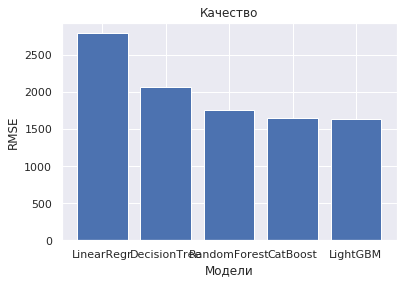

In [65]:
fig, ax = plt.subplots()
ax.bar(model_rating.columns, model_rating.loc['Quality'])
plt.title('Качество')
plt.xlabel('Модели')
plt.ylabel('RMSE')
plt.show()

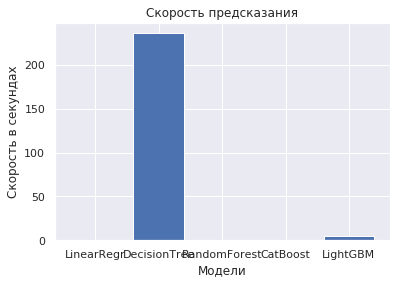

In [66]:
fig, ax = plt.subplots()
ax.bar(model_rating.columns, model_rating.loc['Pred_speed'])
plt.title('Скорость предсказания')
plt.xlabel('Модели')
plt.ylabel('Скорость в секундах')
plt.show()

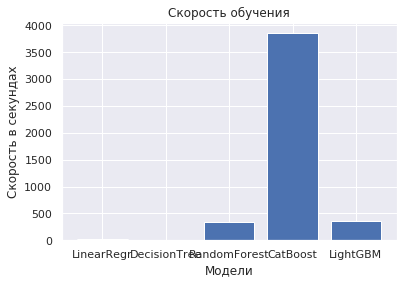

In [67]:
fig, ax = plt.subplots()
ax.bar(model_rating.columns, model_rating.loc['Fit_speed'])
plt.title('Скорость обучения')
plt.xlabel('Модели')
plt.ylabel('Скорость в секундах')
plt.show()

In [68]:
# сравним с примитивной моделью
naive_prediction = np.array([target_train.mean()] * len(target_test))
print(mean_squared_error(naive_prediction, target_test)**0.5)

4492.074468487782


## Общий вывод:

На первом этапе была проведена подготовка данных в том числе: замена нулевых значений с использованием похожих значений, удаление строк в которых эта замена не удалась, а также дубликатов.

На этапе визуализации были выявлены и позже обработанны выбросы.

На полученных данных были обученны следующие модели: Линейная регрессия, Решающее дерево, Случайный лес и два вида бустинга. В процессе этого оценивались следующие характеристики: качетсво предсказания (RMSE), скорость обучения и скорость предсказания.

Наилучшее качество показал LightGBM, он же показал довольно хорошее время на обучении и на предсказании. Следом, по качеству идёт CatBoost, однако он же и показал наибольшее время обучения, оно значительно превосходило ближайщего соседа, а отрыв в качетсве был не на столько велик.

Наименьшее время предсказание у случайного леса и CatBoosta:
Лучшее время обучение у решающего дерева.
Превосходящее конкурентов качество у LightGBM.

Случайный лес является самым оптимальным выбором. При точности, уступающей LightGBM меньше чем на 10%, скорость обучения меньше примерно в 6 раз.

